In [18]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
args = {}
args['dim_h'] = 40            # factor controlling size of hidden layers
args['n_channel'] = 1         # number of channels in the input data (MNIST is 1, aka greyscale)
args['n_z'] = 20              # number of dimensions in latent space. 
args['sigma'] = 1.0           # variance in n_z
args['lambda'] = 0.01           # hyper param for weight of discriminator loss
args['lr'] = 0.0002           # learning rate for Adam optimizer
args['epochs'] = 50            # how many epochs to run for
args['batch_size'] = 256      # batch size for SGD
args['save'] = False          # save weights at each epoch of training if True
args['train'] = False         # train networks if True, else load networks from saved weights

In [20]:
## load MNIST data train and test sets
trainset = datasets.MNIST(
    root='./data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

testset = datasets.MNIST(
    root='./data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

train_loader = DataLoader(
    dataset=trainset,
    batch_size=args['batch_size'],
    shuffle=True
)

test_loader = DataLoader(
    dataset=testset,
    batch_size=args['batch_size'],
    shuffle=False
)

## Try out the vanilla autoencoder 

In [21]:
## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

In [22]:
# instantiate models, and set to train mode
encoder, decoder = Encoder(args), Decoder(args)

if args['train']:
    # specify loss (mean squared error of image reconstruction)
    criterion = nn.MSELoss()

    # use the Adam optimizer, it's always a good choice
    enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

    enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)

    for epoch in range(args['epochs']):
        for images, _ in tqdm(train_loader):
            encoder.train()
            decoder.train()

            encoder.zero_grad()
            decoder.zero_grad()
            batch_size = images.size()[0]

            z_hat = encoder(images)
            x_hat = decoder(z_hat)
            train_recon_loss = criterion(x_hat, images)

            train_recon_loss.backward()

            enc_optim.step()
            dec_optim.step()

        # Run validation set
        encoder.eval()
        decoder.eval()
        for images, _ in tqdm(test_loader):
            z_hat = encoder(images)
            x_hat = decoder(z_hat)
            test_recon_loss = criterion(x_hat, images)

        if args['save']:
            save_path = './save/AE_{}-epoch_{}.pth'
            torch.save(encoder.state_dict(), save_path.format('encoder', epoch))
            torch.save(decoder.state_dict(), save_path.format('decoder', epoch))

        print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {}\n\t\t\tTest Reconstruction Loss: {}".format(
            epoch + 1, 
            args['epochs'], 
            train_recon_loss.data.item(),
            test_recon_loss.data.item()
        ))
else:
    # load some images to place with
    for images, _ in tqdm(train_loader):
        break
        
    # load encoder and decoder weights from checkpoint
    enc_checkpoint = torch.load('save/AE_encoder-best.pth')
    encoder.load_state_dict(enc_checkpoint)

    dec_checkpoint = torch.load('save/AE_decoder-best.pth')
    decoder.load_state_dict(dec_checkpoint)


  0%|          | 0/235 [00:00<?, ?it/s]


## Let's look at some images

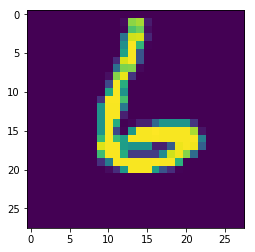

In [23]:
# look at an original image
plt.imshow(images[0,0].numpy())

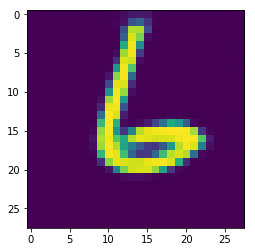

In [24]:
# run same image through autoencoder and take a peak
z_reps = encoder(images)
decoded_images = decoder(z_reps)

plt.imshow(decoded_images[0,0].detach().numpy())

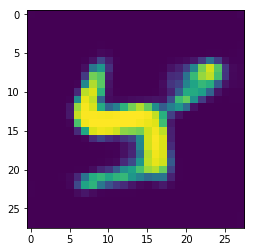

In [161]:
# try a random sample of the latent space
rand_z_reps = torch.randn_like(z_reps)
rand_decoded_images = decoder(rand_z_reps)

plt.imshow(rand_decoded_images[0,0].detach().numpy())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f72e36bf4a8>,
      dtype=object)

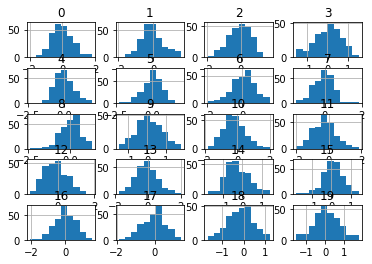

In [50]:
pd.DataFrame(z_reps.detach().numpy()).hist()

## VAE

In [25]:
## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc1 = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
        self.fc2 = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
        
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    
    def forward(self, x):
        h = self.conv(x)
        h = h.squeeze()
        z, mu, logvar = self.bottleneck(h)
        
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

In [26]:
# instantiate models, and set to train mode
encoder, decoder = Encoder(args), Decoder(args)

if args['train']:
    # specify loss (mean squared error of pixel by pixel image reconstruction)
    criterion = nn.MSELoss()

    # use the Adam optimizer, it's always a good choice
    enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

    enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)

    for epoch in range(args['epochs']):
        for images, _ in tqdm(train_loader):
            encoder.train()
            decoder.train()

            encoder.zero_grad()
            decoder.zero_grad()
            batch_size = images.size()[0]

            z_hat, mu, logvar = encoder(images)
            x_hat = decoder(z_hat)
            
            BCE = nn.functional.binary_cross_entropy(
                x_hat.view(-1,784), 
                images.view(-1, 784), 
                reduce=False
            ).sum()
            
            KLD = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            ELBO = BCE - KLD
            ELBO.backward()
                        
            enc_optim.step()
            dec_optim.step()

        # Run validation set
        encoder.eval()
        decoder.eval()
        for images, _ in tqdm(test_loader):
            z_hat, mu, logvar = encoder(images)
            x_hat = decoder(z_hat)
            test_recon_loss = criterion(x_hat, images) # maybe change to BCE?

        if args['save']:
            save_path = './save/VAE_{}-epoch_{}.pth'
            torch.save(encoder.state_dict(), save_path.format('encoder', epoch))
            torch.save(decoder.state_dict(), save_path.format('decoder', epoch))

        print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {} \tKLD:{}\n\t\t\tTest Reconstruction Loss: {}".format(
            epoch + 1, 
            args['epochs'], 
            BCE.data.item(),
            KLD.data.item(),
            test_recon_loss.data.item()
        ))
else:
    # load some images to place with
    for images, _ in tqdm(train_loader):
        break
        
    # load encoder and decoder weights from checkpoint
    enc_checkpoint = torch.load('save/VAE_encoder-best.pth')
    encoder.load_state_dict(enc_checkpoint)

    dec_checkpoint = torch.load('save/VAE_decoder-best.pth')
    decoder.load_state_dict(dec_checkpoint)


  0%|          | 0/235 [00:00<?, ?it/s]


## WAE-GAN!

In [27]:
## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

# define the descriminator
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # main body of discriminator, returns [0,1]
        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x
    
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [28]:
# instantiate discriminator model, and restart encoder and decoder, for fairness. Set to train mode, etc
encoder, decoder, discriminator = Encoder(args), Decoder(args), Discriminator(args)

criterion = nn.MSELoss()

if args['train']:
    enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])
    dis_optim = torch.optim.Adam(discriminator.parameters(), lr = args['lr'])

    enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)
    dis_scheduler = torch.optim.lr_scheduler.StepLR(dis_optim, step_size=30, gamma=0.5)

    # one and -one allow us to control descending / ascending gradient descent
    one = torch.Tensor([1])

    log = {
        'd_z_loss': [],
        'd_z_hat_loss': [],
        'd_loss': [],
        'train_recon_loss': []
    }

    for epoch in range(args['epochs']):

        # train for one epoch -- set nets to train mode
        encoder.train()
        decoder.train()
        discriminator.train()

        for images, _ in tqdm(train_loader):
            # zero gradients for each batch
            encoder.zero_grad()
            decoder.zero_grad()
            discriminator.zero_grad()

            # ======== Train Discriminator ======== #

            # freeze auto encoder params
            frozen_params(decoder)
            frozen_params(encoder)

            # free discriminator params
            free_params(discriminator)

            # run discriminator against randn draws
            z = torch.randn(images.size()[0], args['n_z']) * args['sigma']
            d_z = discriminator(z)

            # run discriminator against encoder z's
#             z_hat, mu, logvar = encoder(images)
            z_hat = encoder(images)
            d_z_hat = discriminator(z_hat)

            # formula for ascending the descriminator -- -one reverses the direction of the gradient.
            d_z_loss = args['lambda']*torch.log(d_z).mean()

            d_z_hat_loss = args['lambda']*torch.log(1 - d_z_hat).mean()

            d_z_loss.backward(-one)
            d_z_hat_loss.backward(-one)

            dis_optim.step()

            # ======== Train Generator ======== #

            # flip which networks are frozen, which are not
            free_params(decoder)
            free_params(encoder)
            frozen_params(discriminator)

            batch_size = images.size()[0]

            # run images
#             z_hat, mu, logvar = encoder(images)
            z_hat = encoder(images)
            x_hat = decoder(z_hat)

            # discriminate latents
#             z_hat2, mu, logvar = encoder(Variable(images.data))
            z_hat2 = encoder(Variable(images.data))
            d_z_hat = discriminator(z_hat2)

            # calculate reconstruction loss
#             train_recon_loss = criterion(x_hat, images)

            # WAE is with whatever cost function I think?
            BCE = nn.functional.binary_cross_entropy(
                x_hat.view(-1,784), 
                images.view(-1, 784), 
                reduce=False
            ).mean()
            
            # calculate discriminator loss
            d_loss = args['lambda'] * (torch.log(d_z_hat)).mean()

            print('BCE',BCE)
            print('d_loss',d_loss)
            
            BCE.backward(one)
            d_loss.backward(-one)

            enc_optim.step()
            dec_optim.step()

            # capture losses of interest
            log['d_z_loss'].append(d_z_loss.data.item())
            log['d_z_hat_loss'].append(d_z_hat_loss.data.item())
            log['d_loss'].append(d_loss.data.item())
            log['train_recon_loss'].append(BCE.data.item())

        # test on test set
        encoder.eval()
        decoder.eval()
        for images, _ in tqdm(test_loader):
#             z_hat, mu, logvar = encoder(images)
            z_hat = encoder(images)
            x_hat = decoder(z_hat)
            test_recon_loss = criterion(x_hat, images)

        
        if args['save']:
            save_path = './save/WAEgan_{}-epoch_{}.pth'
            torch.save(encoder.state_dict(), save_path.format('encoder', epoch))
            torch.save(decoder.state_dict(), save_path.format('decoder', epoch))
            torch.save(discriminator.state_dict(), save_path.format('discriminator', epoch))

        # print stats after each epoch
        print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {} d loss: {}, \n\t\t\tTest Reconstruction Loss:{}".format(
            epoch + 1, 
            args['epochs'], 
            BCE.data.item(),
            d_loss.data.item(),
            test_recon_loss.data.item()
        ))
        
else:
    # load some images to place with
    for images, _ in tqdm(train_loader):
        break
        
    enc_checkpoint = torch.load('save/WAEgan_encoder-best.pth')
    encoder.load_state_dict(enc_checkpoint)

    dec_checkpoint = torch.load('save/WAEgan_decoder-best.pth')
    decoder.load_state_dict(dec_checkpoint)
    
    dec_checkpoint = torch.load('save/WAEgan_discriminator-best.pth')
    discriminator.load_state_dict(dec_checkpoint)


  0%|          | 0/235 [00:00<?, ?it/s]


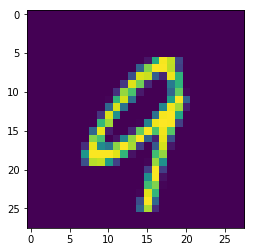

In [29]:
# look at an original image
plt.imshow(images[0,0].numpy())

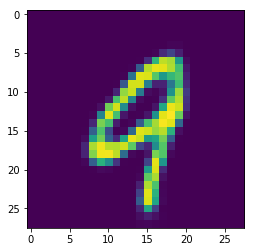

In [31]:
# run same image through autoencoder and take a peak
z_reps = encoder(images)
decoded_images = decoder(z_reps)

plt.imshow(decoded_images[0,0].detach().numpy())

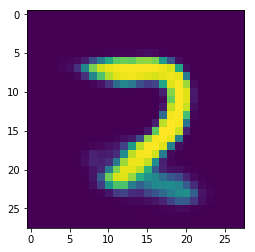

In [32]:
# try a random sample of the latent space
rand_z_reps = torch.randn_like(z_reps)
rand_decoded_images = decoder(rand_z_reps)

plt.imshow(rand_decoded_images[0,0].detach().numpy())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf0de240f0>,
      dtype=object)

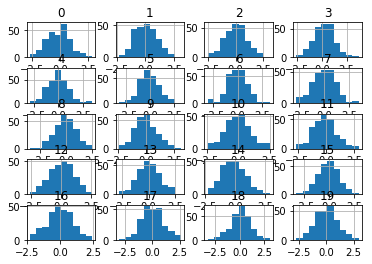

In [33]:
fake_z_reps = torch.randn_like(z_reps)
pd.DataFrame(fake_z_reps.numpy()).hist()